In [4]:
# import necessary libraries
import os
import itertools
import numpy as np
import gym
from gym import spaces
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3 import PPO, A2C
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# block on the container yard
class Block:
    id_obj = itertools.count()
    
    # block consists of locations, block size can be specified (max: rows, bays, tiers)
    def __init__(self, rows, bays, tiers):
        self.block_id = "B" + str(next(Block.id_obj) + 1)
        self.rows = rows
        self.bays = bays
        self.tiers = tiers
        self.locations = [Location(row, bay, tier) \
                          for row in range(1, rows + 1) \
                          for bay in range(1, bays + 1) \
                          for tier in range(1, tiers + 1)]
        
    # 3D array representation of wether location has a container (1) or not (0)
    def current_state(self):
        state = np.array([], dtype=np.int32)
        for location in self.locations:
            if location.container is None:
                state = np.append(state, [0])
            else:
                state = np.append(state, [1])
        state = state.reshape(self.rows, self.bays, self.tiers)
        return state
    
    # find location by (row, bay, tier) coordinate
    def location_by_coordinate(self, row, bay, tier):
        target_location = None
        for location in self.locations:
            if location.row == row and location.bay == bay and location.tier == tier:
                target_location = location
                break
        if target_location is None:
            raise TypeError(f"Couldn't find location with (row, bay, tier) coordinate ({row, bay, tier})")
        else:
            return target_location
    
    # delete all containers from locations
    def empty_out(self):
        for location in self.locations:
            location.container = None
        
    # shows all information
    def info(self):
        return(f"block id: {self.block_id}, "\
               f"maximum rows: {self.rows}, "\
               f"maximum bays: {self.bays}, "\
               f"maximum tiers: {self.tiers}, "\
               f"location amount: {len(self.locations)}\n")
        
        
# location in a block
class Location:
    id_obj = itertools.count()
    
    # locations have no container in them upon creation
    def __init__(self, row, bay, tier, container=None):
        self.location_id = "L" + str(next(Location.id_obj) + 1)
        self.row = row
        self.bay = bay
        self.tier = tier
        self.container = container
        
    # give (row, bay, tier) coordinate of location in block
    def coordinate(self):
        return self.row, self.bay, self.tier
        
    # shows all information
    def info(self):
        container_info = None
        if self.container is not None:
            container_info = self.container.container_id
        return(f"location id: {self.location_id}, "\
               f"row: {self.row}, "\
               f"bay: {self.bay}, "\
               f"tier: {self.tier}, "\
               f"container: {container_info}\n")
        
        
# container on a vessel or location
class Container:
    id_obj = itertools.count()
    
    # container has an origin vessel and destination vessel
    def __init__(self, origin_vessel_id, destination_vessel_id):
        self.container_id = 'C' + str(next(Container.id_obj) + 1)
        self.origin_vessel_id = origin_vessel_id
        self.destination_vessel_id = destination_vessel_id
        
    # shows all information
    def info(self):
        return(f"container id: {self.container_id}, "\
               f"origin vessel id: {self.origin_vessel_id}, "\
               f"destination vessel id: {self.destination_vessel_id}\n")
        
        
# vessel with containers
class Vessel:
    id_obj = itertools.count()
    
    # call containers upon creating a vessel have the same destination
    def __init__(self, max_containers, container_destination_vessel_id, dock):
        self.vessel_id = 'V' + str(next(Vessel.id_obj) + 1)
        self.max_containers = max_containers
        self.container_destination_vessel_id = container_destination_vessel_id
        self.containers = [Container(self.vessel_id, container_destination_vessel_id) \
                           for container in range(0, max_containers)]
        self.dock = dock
        self.dock.vessels.append(self)
    
    # delete all containers and recreate them
    def regenerate_containers(self):
        self.containers = [Container(self.vessel_id, self.container_destination_vessel_id) \
                           for container in range(0, self.max_containers)]
        
    # returns the amount of containers in the vessel
    def container_amount(self):
        return len(self.containers)
        
    # shows all information
    def info(self):
        return(f"vessel id: {self.vessel_id}, "\
               f"maximum containers: {self.max_containers}, "\
               f"container amount: {self.container_amount()}, "\
               f"docked at: {self.dock.dock_id}\n")
        
        
# dock in which vessels are stored
class Dock:
    id_obj = itertools.count()
    
    # dock contains a list of vessels
    def __init__(self):
        self.dock_id = 'D' + str(next(Dock.id_obj) + 1)
        self.vessels = []
    
    # call the delete and reacreate containers for every vessel in the dock
    def regenerate_containers(self):
        for vessel in self.vessels:
            vessel.regenerate_containers()
        
    # returns the sum of all containers of every vessels in the dock
    def container_amount(self):
        container_amount = 0
        for vessel in self.vessels:
            container_amount += vessel.container_amount()
        return container_amount
        
    # shows all information
    def info(self):
        return(f"dock id: {self.dock_id}, "\
               f"vessel amount: {len(self.vessels)}, "\
               f"container amount: {self.container_amount()}\n")
    

In [9]:
class CustomEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, rows=3, bays=3, tiers=1, containers_per_vessel=4):
        super(CustomEnv, self).__init__()
        # objects needed in the environment
        self.block = Block(rows, bays, tiers)
        self.dock = Dock()
        self.vessel1 = Vessel(containers_per_vessel, 'V98', self.dock)
        self.vessel2 = Vessel(containers_per_vessel, 'V99', self.dock)
        
        # map every location as an action
        self.action_dict = {action: location for action, location in enumerate(self.block.locations)}
        
        # define action space and observation space
        n_actions = len(self.action_dict)
        self.action_space =  spaces.Discrete(n_actions)
        self.observation_space = spaces.Box(low=0, high=1, \
                                            shape=(self.block.rows, self.block.bays, self.block.tiers), dtype=np.int32)
        
    def step(self, action):
        reward = 0
        done = False
        
        # get location to be used
        location = self.action_dict.get(action)
        
        # get vessel which still has a container in it
        vessel = None
        for ves in self.dock.vessels:
            if len(ves.containers) > 0:
                vessel = ves
                break
        
        # check if location already has container in it
        location_is_available = (location.container is None)
        if location_is_available == False:
            reward -= 10
        
        # move container to location if conditions are met
        container_is_placed = False
        if (location_is_available):
            moving_container = vessel.containers.pop(-1)
            location.container = moving_container
            container_is_placed = True
            reward += 20
            
        # reward if placed adjecent to a container with similar destination
        if (container_is_placed == True):
            row, bay, tier = location.coordinate()
            row_right = row + 1
            if row_right <= self.block.rows:
                location_right = self.block.location_by_coordinate(row_right, bay, tier)
                if location_right.container is not None:
                    if location_right.container.destination_vessel_id == location.container.destination_vessel_id:
                        reward += 5
            row_left = row - 1
            if row_left > 0:
                location_left = self.block.location_by_coordinate(row_left, bay, tier)
                if location_left.container is not None:
                    if location_left.container.destination_vessel_id == location.container.destination_vessel_id:
                        reward += 5
        
        # new observation
        observation = self.block.current_state()
        info = {}
        
        # done if all containers have been moved out of the vessels in dock
        done = (self.dock.container_amount() == 0)
        
        return observation, reward, done, info
    
    def reset(self):
        self.block.empty_out()
        self.dock.regenerate_containers()
        observation = self.block.current_state()
        return observation
    
    def render(mode='rgb_array'):
        pass
        
    def close (self):
        pass
    
    
test_env = CustomEnv()

In [5]:
# check if custom environment meets gym requirements
check_env(test_env, warn=True)

In [10]:
class Visualizer:
    def __init__(self):
        pass
        
    def render(self, block):
        # clear any figure and axes if present
        plt.clf()
        
        # create axes and get data
        axes = [block.rows, block.bays, block.tiers]
        data = block.current_state()
        
        # map each color string to a RGBA array
        alpha = 0.6
        colors = ['magenta', 'cyan', 'yellow', 'red', 'green', 'blue']
        RGBAs = [[1, 0, 1, alpha], [0, 1, 1, alpha], [1, 1, 0, alpha], \
                 [1, 0, 0, alpha], [0, 1, 0, alpha], [0, 0, 1, alpha]]
        color_RGBA = {}
        for i in range(0, len(colors)):
            color_RGBA.update({colors[i]: RGBAs[i]})
        #print("color_RGBA: ", color_RGBA)
            
        # get container destination per location in block
        locations = block.locations
        destinations = []
        for location in locations:
            if location.container is not None:
                destinations.append(location.container.destination_vessel_id)
            else:
                destinations.append(None)
        #print("destinations: ", destinations)
                
        # get all unique destinations, first remove None then remove duplicates
        unique_destinations = list(filter(lambda element: element is not None, destinations))
        unique_destinations = list(set(unique_destinations))
        #print("unique_destinations: ", unique_destinations)
        
        # map each unique destination to a color string
        destination_color = {}
        for i in range(0, len(unique_destinations)):
            destination_color.update({unique_destinations[i]: colors[i]})
        #print("destination_color: ", destination_color)
        
        # map each unique destination to a RGBA array
        destination_RGBA = {}
        for destination in unique_destinations:
            color = destination_color.get(destination)
            RGBA = color_RGBA.get(color)
            destination_RGBA.update({destination: RGBA})
        #print("destination_RGBA: ", destination_RGBA)
        
        # create 4D facecolor array
        facecolors = np.array([], dtype=np.float32)
        for destination in destinations:
            if destination is not None:
                RGBA = destination_RGBA.get(destination)
                facecolors = np.append(facecolors, RGBA)
            else:
                RGBA = [None, None, None, None]
                facecolors = np.append(facecolors, RGBA)
        #print("facecolors: ", facecolors)
        facecolors = facecolors.reshape(block.rows, block.bays, block.tiers, 4)
        
        # plot figure
        fig_size = (7, 7)
        fig = plt.figure(figsize=fig_size)
        ax = fig.add_subplot(111, projection='3d')
        
        # customize axes
        font_size = 12
        ax.set_xlabel('row', fontsize=font_size, rotation=0)
        ax.set_xticks([n for n in range(0, block.rows)])
        ax.set_ylabel('bay', fontsize=font_size, rotation=0)
        ax.set_yticks([n for n in range(0, block.bays)])
        ax.set_zlabel('tier', fontsize=font_size, rotation=0)
        ax.set_zticks([n for n in range(0, block.tiers)])
        
        # add legend showing which color is which destination
        patches = []
        for destination in destination_color:
            patch = mpatches.Patch(color=destination_color.get(destination), label=destination)
            patches.append(patch)
        ax.legend(handles=patches)
        
        # change aspect ratio create container shape
        aspect_ratio = (4, 8, 1)
        ax.set_box_aspect(aspect_ratio)
        
        # use voxels to portray containers
        ax.voxels(data, facecolors=facecolors, edgecolors='k')
        plt.show()
        
visualizer = Visualizer()

In [7]:
# test out the environment action space and observation space
print(test_env.observation_space)
print(test_env.observation_space.sample())
print(test_env.action_space)
print(test_env.action_space.sample())

Box([[[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]], [[[1]
  [1]
  [1]]

 [[1]
  [1]
  [1]]

 [[1]
  [1]
  [1]]], (3, 3, 1), int32)
[[[1]
  [1]
  [0]]

 [[0]
  [0]
  [1]]

 [[0]
  [0]
  [0]]]
Discrete(9)
8


step: 0
reward: 20
score: 20
observation: [[[0], [0], [0]], [[0], [0], [0]], [[0], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

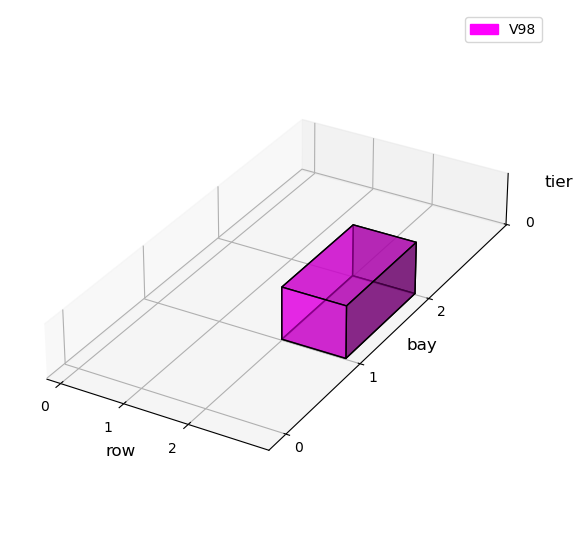

step: 1
reward: 20
score: 40
observation: [[[1], [0], [0]], [[0], [0], [0]], [[0], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

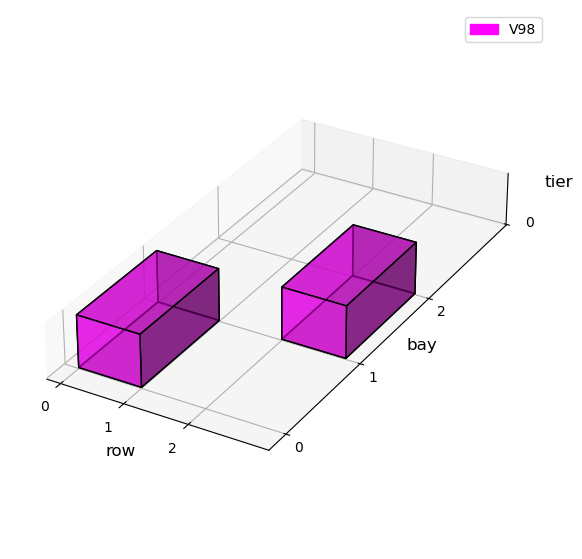

step: 2
reward: 25
score: 65
observation: [[[1], [0], [0]], [[0], [1], [0]], [[0], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

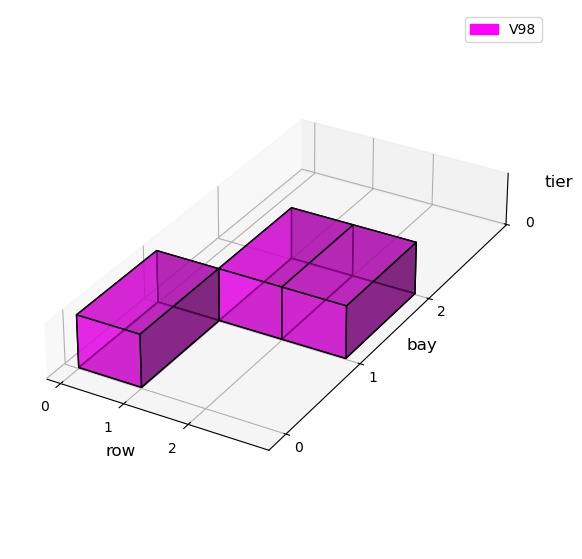

step: 3
reward: 25
score: 90
observation: [[[1], [0], [0]], [[1], [1], [0]], [[0], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

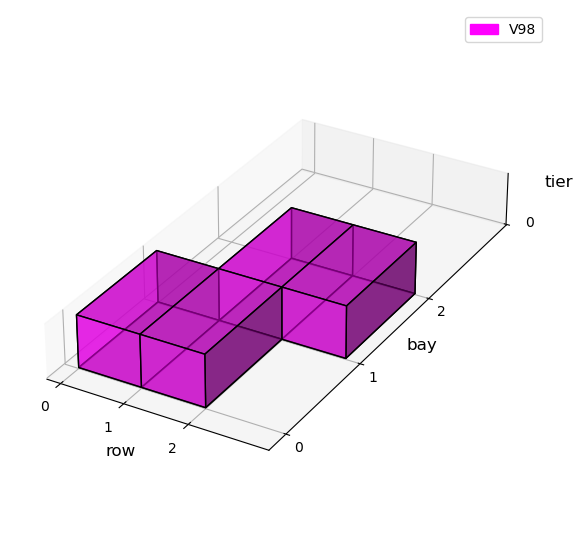

step: 4
reward: 20
score: 110
observation: [[[1], [0], [0]], [[1], [1], [0]], [[1], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

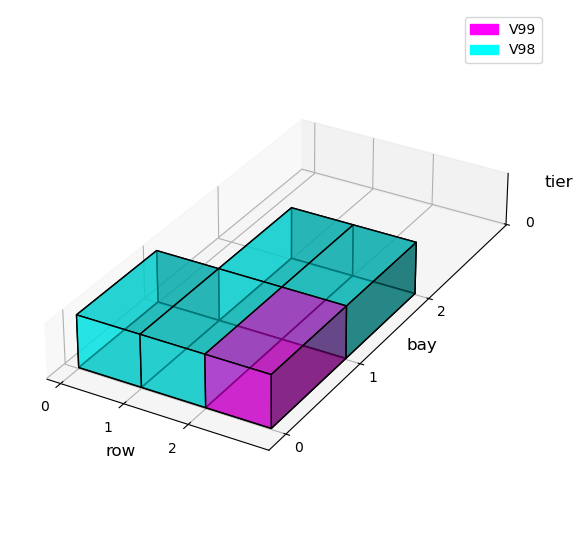

step: 5
reward: 20
score: 130
observation: [[[1], [0], [0]], [[1], [1], [1]], [[1], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

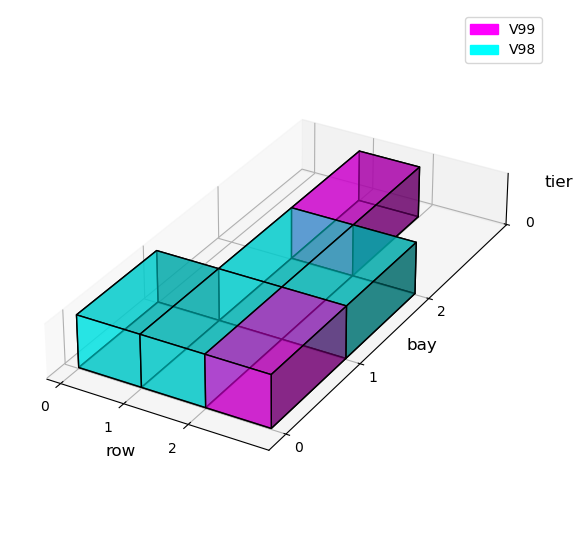

step: 6
reward: -10
score: 120
observation: [[[1], [0], [0]], [[1], [1], [1]], [[1], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

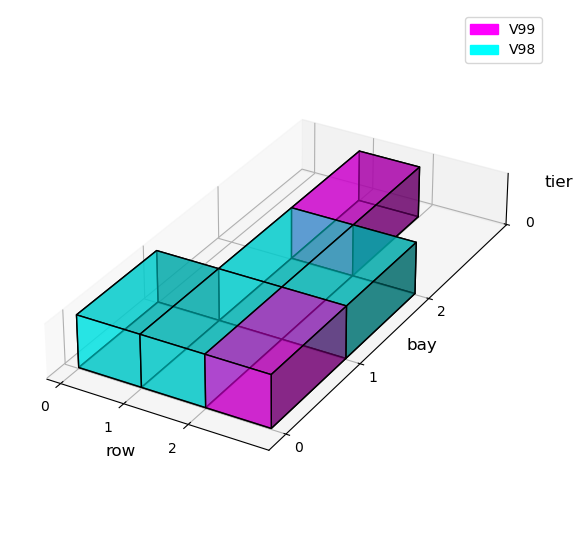

step: 7
reward: -10
score: 110
observation: [[[1], [0], [0]], [[1], [1], [1]], [[1], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

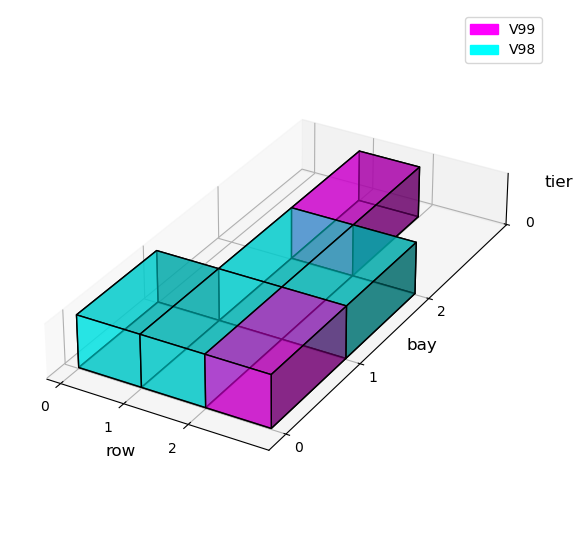

step: 8
reward: 20
score: 130
observation: [[[1], [1], [0]], [[1], [1], [1]], [[1], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

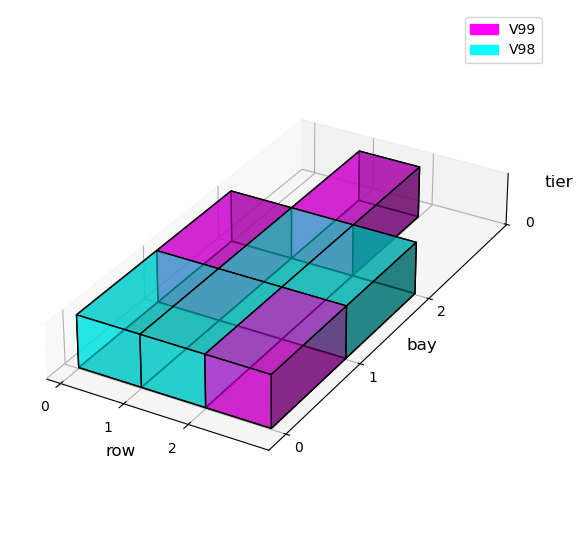

step: 9
reward: -10
score: 120
observation: [[[1], [1], [0]], [[1], [1], [1]], [[1], [1], [0]]]
done: False



<Figure size 640x480 with 0 Axes>

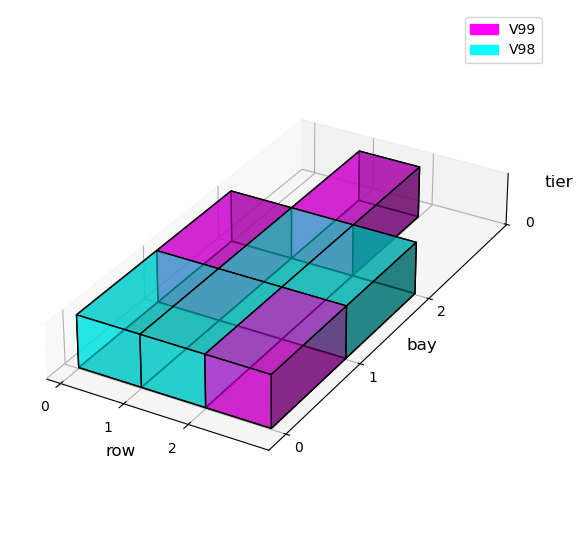

step: 10
reward: 25
score: 145
observation: [[[1], [1], [1]], [[1], [1], [1]], [[1], [1], [0]]]
done: True



<Figure size 640x480 with 0 Axes>

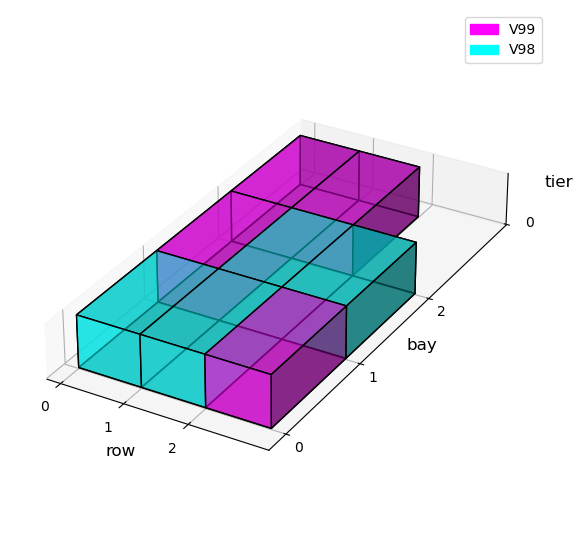

In [11]:
# simulate placing of containers and visualizing
test_env.reset()
n_steps = 20
score = 0
for step in range(0, n_steps):
    print(f"step: {step}")
    action = np.random.randint(low=0, high=len(test_env.block.locations) - 1)
    obs, reward, done, info = test_env.step(action)
    score += reward
    print(f"reward: {reward}")
    print(f"score: {score}")
    print(f"observation: {obs.tolist()}")
    print(f"done: {done}\n")
    visualizer.render(test_env.block)
    if done:
        break

In [12]:
# create directories to save trained models and logs in
models_dir_ppo = "models/PPO"
models_dir_a2c = "models/A2C"
logdir = "logs"

os.makedirs(models_dir_ppo, exist_ok=True)
os.makedirs(models_dir_a2c, exist_ok=True)
os.makedirs(logdir, exist_ok=True)

In [13]:
# wrap environment to vectorized environments
n_envs = 8
env = CustomEnv()
env = make_vec_env(lambda: env, n_envs=n_envs)

In [14]:
# create and train PPO model with different hyperparameter values
ppo_timesteps = 50000

In [ ]:
# TRAINING STARTS HERE

In [12]:
# learning rate
ppo_learning_rates = [0.03, 0.003, 0.0003, 0.00003, 0.000003]
for learning_rate in ppo_learning_rates:
    model_ppo = PPO('MlpPolicy', env, learning_rate=learning_rate, batch_size=32, verbose=1, tensorboard_log=logdir)
    model_ppo.learn(total_timesteps=ppo_timesteps, reset_num_timesteps=False, \
    tb_log_name=f"PPO-learning_rate={learning_rate}")
    model_ppo.save(f"{models_dir_ppo}/PPO-learning_rate={learning_rate}")

Using cpu device
Logging to logs/PPO-learning_rate=0.03_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | 81.5     |
| time/              |          |
|    fps             | 10392    |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 16384    |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 17.1      |
|    ep_rew_mean          | 81.5      |
| time/                   |           |
|    fps                  | 2488      |
|    iterations           | 2         |
|    time_elapsed         | 13        |
|    total_timesteps      | 32768     |
| train/                  |           |
|    approx_kl            | 27.280323 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.0286   |
|    explained_variance   | -0.00017  |
| 

In [13]:
# gamma
ppo_gammas = [0.90, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
for gamma in ppo_gammas:
    model_ppo = PPO('MlpPolicy', env, gamma=gamma, batch_size=32, verbose=1, tensorboard_log=logdir)
    model_ppo.learn(total_timesteps=ppo_timesteps, reset_num_timesteps=False, tb_log_name=f"PPO-gamma={gamma}")
    model_ppo.save(f"{models_dir_ppo}/PPO-gamma={gamma}")

Using cpu device
Logging to logs/PPO-gamma=0.9_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.8     |
|    ep_rew_mean     | 86.5     |
| time/              |          |
|    fps             | 10411    |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 16384    |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 17.3       |
|    ep_rew_mean          | 87.2       |
| time/                   |            |
|    fps                  | 2471       |
|    iterations           | 2          |
|    time_elapsed         | 13         |
|    total_timesteps      | 32768      |
| train/                  |            |
|    approx_kl            | 0.00826847 |
|    clip_fraction        | 0.099      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.19      |
|    explained_variance   | -0.000554

In [11]:
# gae_lambda
ppo_gae_lambdas = [0.80, 0.85, 0.90, 0.95]
for gae_lambda in ppo_gae_lambdas:
    model_ppo = PPO('MlpPolicy', env, gae_lambda=gae_lambda, batch_size=32, verbose=1, tensorboard_log=logdir)
    model_ppo.learn(total_timesteps=ppo_timesteps, reset_num_timesteps=False, tb_log_name=f"PPO-gae_lambda={gae_lambda}")
    model_ppo.save(f"{models_dir_ppo}/PPO-gae_lambda={gae_lambda}")

Using cpu device
Logging to logs/PPO-gae_lambda=0.8_0


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | 88.5     |
| time/              |          |
|    fps             | 10349    |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 15.8        |
|    ep_rew_mean          | 85.8        |
| time/                   |             |
|    fps                  | 2469        |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.010136616 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | -0.00021    |
|    learning_rate        | 0.

In [14]:
# ent_coef
ppo_ent_coefs = [0.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
for ent_coef in ppo_ent_coefs:
    model_ppo = PPO('MlpPolicy', env, ent_coef=ent_coef, batch_size=32, verbose=1, tensorboard_log=logdir)
    model_ppo.learn(total_timesteps=ppo_timesteps, reset_num_timesteps=False, tb_log_name=f"PPO-ent_coef={ent_coef}")
    model_ppo.save(f"{models_dir_ppo}/PPO-ent_coef={ent_coef}")

Using cpu device
Logging to logs/PPO-ent_coef=0.0_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.8     |
|    ep_rew_mean     | 87.4     |
| time/              |          |
|    fps             | 10314    |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 16384    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 16           |
|    ep_rew_mean          | 97.2         |
| time/                   |              |
|    fps                  | 2432         |
|    iterations           | 2            |
|    time_elapsed         | 13           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0057497667 |
|    clip_fraction        | 0.0623       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.19        |
|    e

In [15]:
# vf_coef
ppo_vf_coefs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for vf_coef in ppo_vf_coefs:
    model_ppo = PPO('MlpPolicy', env, vf_coef=vf_coef, batch_size=32, verbose=1, tensorboard_log=logdir)
    model_ppo.learn(total_timesteps=ppo_timesteps, reset_num_timesteps=False, tb_log_name=f"PPO-vf_coef={vf_coef}")
    model_ppo.save(f"{models_dir_ppo}/PPO-vf_coef={vf_coef}")

Using cpu device
Logging to logs/PPO-vf_coef=0.1_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | 84       |
| time/              |          |
|    fps             | 8613     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 16384    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 15.5         |
|    ep_rew_mean          | 95           |
| time/                   |              |
|    fps                  | 1858         |
|    iterations           | 2            |
|    time_elapsed         | 17           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0066679213 |
|    clip_fraction        | 0.0626       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.19        |
|    ex

In [15]:
# create and train A2C model with different hyperparameter values
model_a2c = A2C('MlpPolicy', env, learning_rate=0.0007, n_steps=5, verbose=1, tensorboard_log=logdir)

Using cpu device


/opt/jupyterhub/anaconda/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [112]:
# block with locations
block = Block(3, 3, 1)
print(block.info())
for location in block.locations:
    print(location.location_id, location.row, location.bay, location.tier, location.container is not None)
print()

# location in a block
print(block.locations[0].info())

# dock which can have vessels
dock = Dock()
print(dock.info())

# vessel with containers
vessel1 = Vessel(4, 'V9', dock)
vessel2 = Vessel(4, 'V10', dock)
print(vessel1.info())
print(dock.info())

# container in a vessel
print(vessel1.containers[0].info())


block id: B2, maximum rows: 3, maximum bays: 3, maximum tiers: 1, location amount: 9

L10 1 1 1 False
L11 1 2 1 False
L12 1 3 1 False
L13 2 1 1 False
L14 2 2 1 False
L15 2 3 1 False
L16 3 1 1 False
L17 3 2 1 False
L18 3 3 1 False

location id: L10, row: 1, bay: 1, tier: 1, container: None

dock id: D2, vessel amount: 0, container amount: 0

vessel id: V3, maximum containers: 4, container amount: 4, docked at: D2

dock id: D2, vessel amount: 2, container amount: 8

container id: C105, origin vessel id: V3, destination vessel id: V9

vessel V1 not found
location L1 not found
